# Feature Imputation with a Heat Flux Dataset
https://www.kaggle.com/c/playground-series-s3e15




In [47]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

# Описание признаков

In [48]:
data = pd.read_csv("./data/data.csv")

### Описание колонок

author - Имя человека или группы, проводившей эксперимент

geometry - Тип геометрии, используемой в эксперименте, например, труба или кольцевое пространство

pressure [МПа] - Давление жидкости в эксперименте

mass_flux [кг / м2-с] - Массовый поток жидкости в эксперименте

D_e [мм] - Эквивалентный диаметр экспериментальной геометрии

D_h [мм] - Гидравлический диаметр экспериментальной геометрии

length [мм] - Длина экспериментальной геометрии, измеряемая в миллиметрах

chf_exp [МВт / м2] - Экспериментальный критический тепловой поток

**X_e_out [-] (target)** - Качество жидкости на выходе в эксперименте


In [49]:
data

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8
...,...,...,...,...,...,...,...,...,...,...
31639,31639,Thompson,NaN,NaN,1736.0,0.0886,NaN,7.8,591.0,2.3
31640,31640,NaN,NaN,13.79,NaN,NaN,4.7,4.7,NaN,3.9
31641,31641,Thompson,NaN,18.27,658.0,-0.1224,3.0,3.0,150.0,2.3
31642,31642,Thompson,tube,6.89,3825.0,NaN,23.6,23.6,1972.0,3.7


In [50]:
data.rename(columns={'pressure [MPa]':'pressure',
                     'mass_flux [kg/m2-s]':'mass_flux',
                     'x_e_out [-]':'x_e_out', 
                     'D_e [mm]':'D_e', 
                     'D_h [mm]':'D_h', 
                     'length [mm]':'length',
                     'chf_exp [MW/m2]':'chf_exp'}, inplace=True)

In [51]:
data.describe()

,id,pressure,mass_flux,x_e_out,D_e,D_h,length,chf_exp
count,31644.000000,27192.000000,26853.000000,21229.000000,26156.000000,27055.000000,26885.000000,31644.000000
mean,15821.500000,10.640747,3068.011023,-0.000453,8.629255,14.174330,832.987391,3.796985
std,9134.980296,4.333683,1777.032080,0.100911,5.185692,19.838489,672.299239,1.983991
min,0.000000,0.100000,0.000000,-0.866700,1.000000,1.000000,10.000000,0.800000
25%,7910.750000,6.890000,1519.000000,-0.046600,5.000000,5.600000,318.000000,2.400000
50%,15821.500000,11.070000,2731.000000,0.003800,7.800000,10.000000,610.000000,3.400000
75%,23732.250000,13.790000,4069.000000,0.064800,10.800000,11.500000,914.000000,4.600000
max,31643.000000,20.680000,7975.000000,0.232000,37.500000,120.000000,3048.000000,19.300000


# Предобработка данных

### Трансформация признаков

In [52]:
data['D_e'] = np.log(data['D_e'])
data['D_h'] = np.log(data['D_h'])
data['length'] = np.log(data['length'])
data['chf_exp'] = np.log(data['chf_exp'])

### Заполнение пропусков

Заполнение NaN для D_e через D_h

In [53]:
data.loc[data['D_e'].isna(), 'D_e'] = data[data['D_e'].isna()]['D_h']
data.loc[data['D_h'].isna(), 'D_h'] = data[data['D_h'].isna()]['D_e']

In [54]:
X_train, y_train = data[~data.x_e_out.isna()][data.columns.drop('x_e_out')], data[~data.x_e_out.isna()]['x_e_out']
X_test, y_test = data[data.x_e_out.isna()][data.columns.drop('x_e_out')], data[data.x_e_out.isna()]['x_e_out']
print(y_train.shape, y_test.shape)

(21229,) (10415,)


In [55]:
numerical_features = data.select_dtypes(include=['number']).columns
categorial_features = data.columns.drop(numerical_features)
numerical_features = numerical_features.drop(['id', 'x_e_out'])

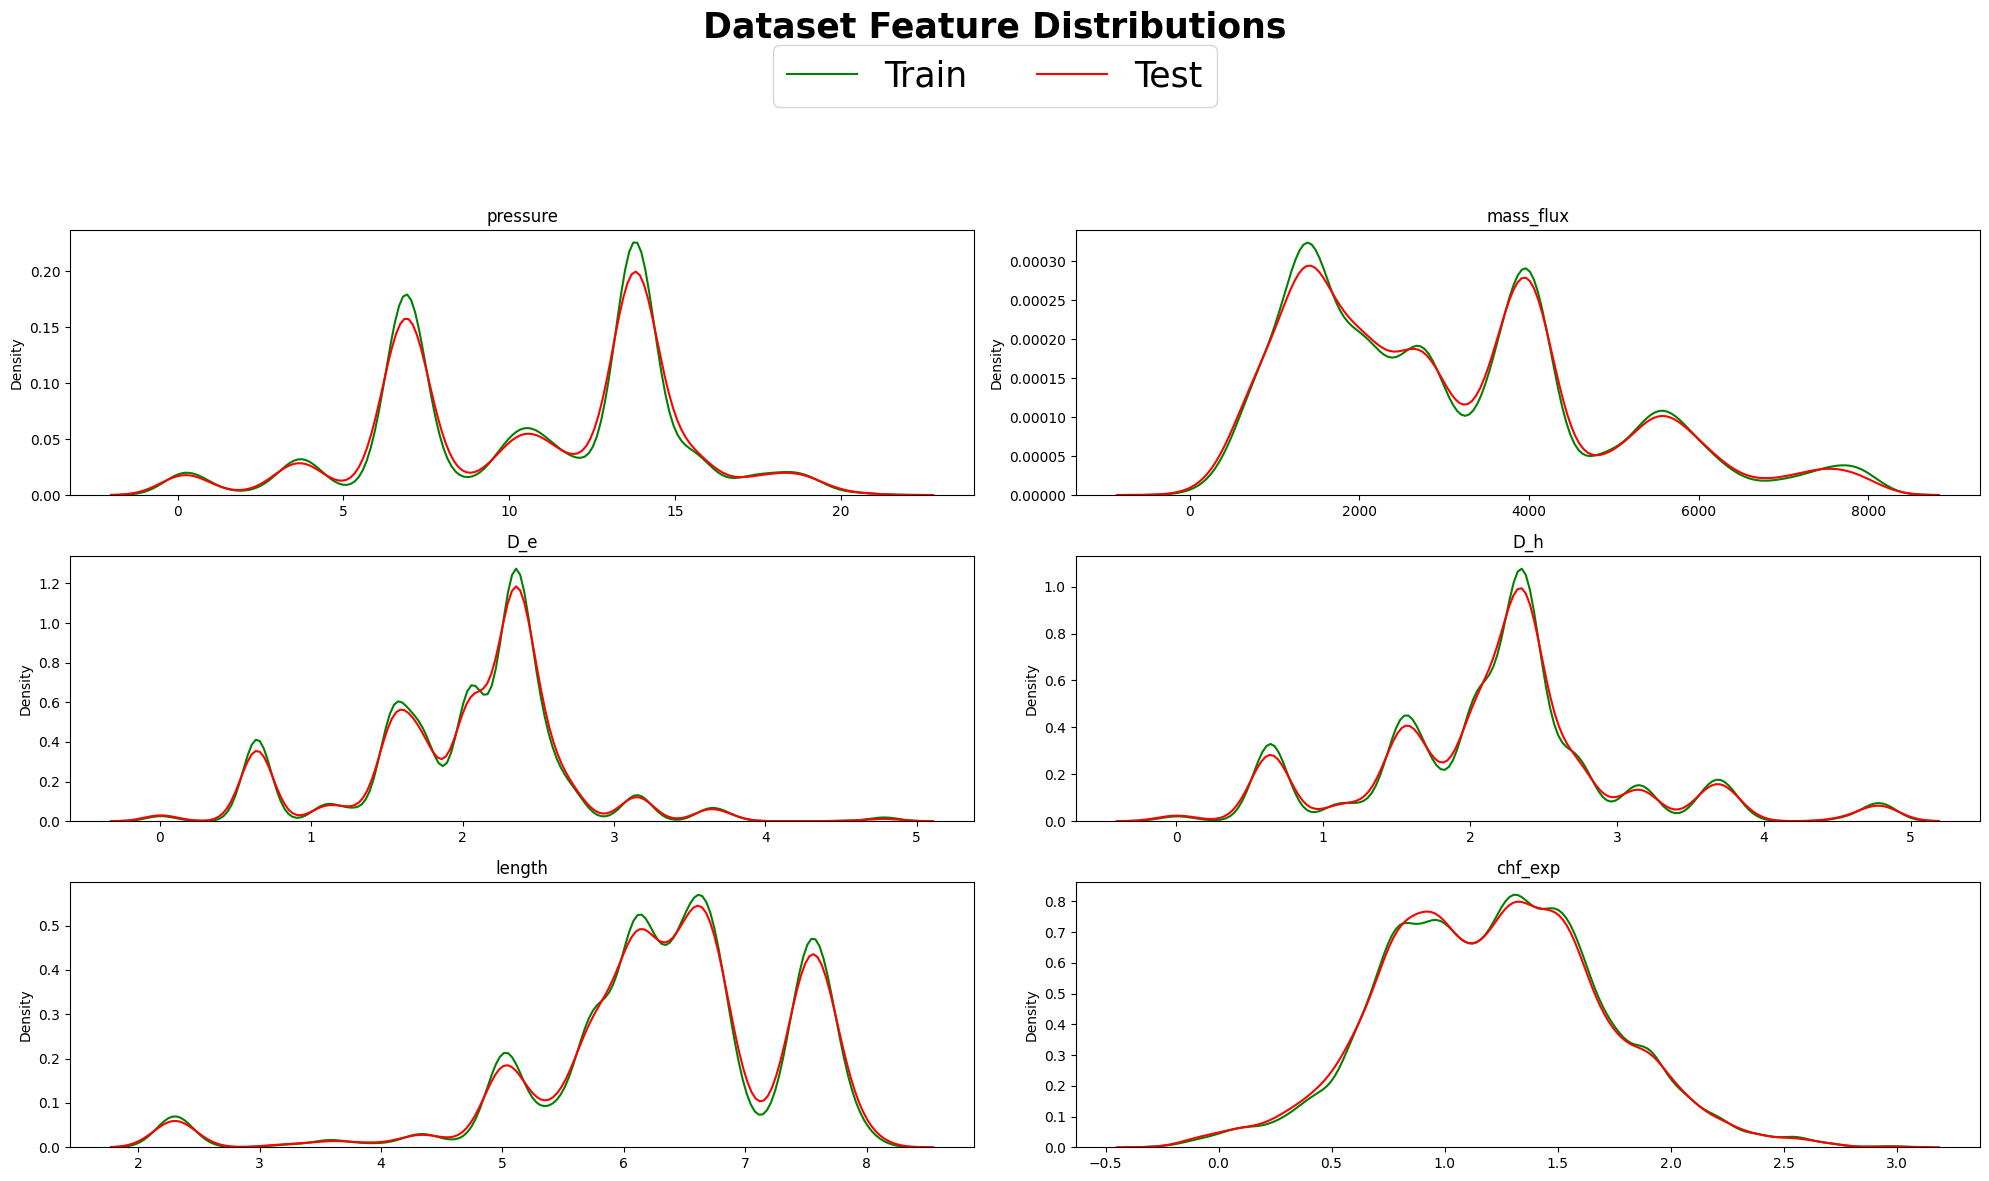

In [56]:
features = numerical_features
n_bins = 100
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 2
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        X_train[column], label='Train',
        ax=ax[i], color='g'
    )
    
    sns.kdeplot(
        X_test[column], label='Test',
        ax=ax[i], color='r'
    )

    # titles
    ax[i].set_title(f'{column}');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Dataset Feature Distributions\n\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.965), fontsize=25, ncol=3)
plt.tight_layout()

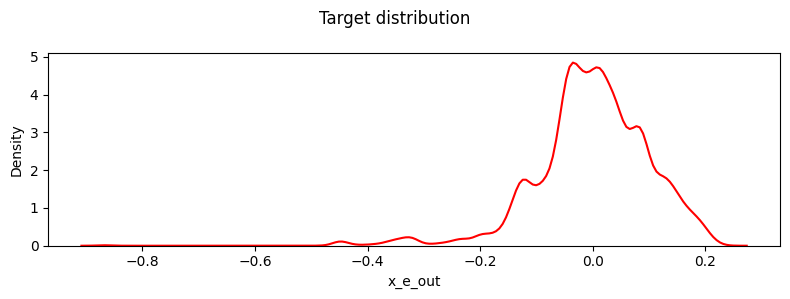

In [57]:
fig = plt.figure(figsize=(8,3))
sns.kdeplot(y_train, label='Train distribution', color='r')
fig.suptitle(f'Target distribution')
plt.tight_layout()

In [58]:
def fillna_cat_features(X_train, X_test):
    for col in categorial_features:
        X_train[col+'_is_NA'] = np.where(X_train[col].isna(), 1, 0)
        X_test[col+'_is_NA'] = np.where(X_test[col].isna(), 1, 0)
        
    X_train['author'] = X_train['author'].fillna(X_train['author'].mode()[0])
    X_test['author'] = X_test['author'].fillna(X_train['author'].mode()[0])

    mode_by_author = X_train.groupby('author')['geometry'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    X_train['geometry'] = X_train['geometry'].fillna(X_train['author'].map(mode_by_author))
    X_test['geometry'] = X_test['geometry'].fillna(X_test['author'].map(mode_by_author))

    return X_train[categorial_features].isna().sum()

fillna_cat_features(X_train, X_test)

author      0
geometry    0
dtype: int64

In [59]:
def fillna_num_features(X_train, X_test):
    for col in numerical_features:
        if X_train[col].isnull().sum() > 0 or X_test[col].isnull().sum() > 0:
            mode_by_geometry = X_train.groupby('geometry')[col].apply(lambda x: x.mean())
            X_train[col] = X_train[col].fillna(X_train['geometry'].map(mode_by_geometry))
            X_test[col] = X_test[col].fillna(X_test['geometry'].map(mode_by_geometry))

    return X_train[numerical_features].isna().sum()

fillna_num_features(X_train, X_test)

pressure     0
mass_flux    0
D_e          0
D_h          0
length       0
chf_exp      0
dtype: int64

### Кодирование признаков

In [60]:
X_train

,id,author,geometry,pressure,mass_flux,D_e,D_h,length,chf_exp,author_is_NA,geometry_is_NA
0,0,Thompson,tube,7.000000,3770.000000,2.379546,2.379546,6.068426,1.280934,0,0
1,1,Thompson,tube,11.157708,6049.000000,2.332144,2.332144,6.635947,1.824549,0,0
2,2,Thompson,tube,13.790000,2034.000000,2.041220,2.041220,6.124683,0.916291,0,1
3,3,Beus,annulus,13.790000,3679.000000,1.722767,2.721295,7.665753,1.098612,0,0
5,5,Thompson,tube,17.240000,3648.000000,0.641854,0.641854,6.545350,1.280934,1,1
...,...,...,...,...,...,...,...,...,...,...,...
31636,31636,Thompson,tube,12.070000,3235.129469,0.641854,0.641854,5.023881,1.686399,1,1
31638,31638,Thompson,tube,11.157708,3648.000000,1.547563,1.547563,5.762051,2.197225,0,0
31639,31639,Thompson,tube,11.157708,1736.000000,2.054124,2.054124,6.381816,0.832909,0,1
31641,31641,Thompson,tube,18.270000,658.000000,1.098612,1.098612,5.010635,0.832909,0,1


In [61]:
ohe = OneHotEncoder()

train_encoded = ohe.fit_transform(X_train[categorial_features])
test_encoded = ohe.transform(X_test[categorial_features])

encoded_cols = ohe.get_feature_names_out(categorial_features)

X_train_cat_encoded = pd.DataFrame(train_encoded.toarray(), columns=encoded_cols, index=X_train.index)
X_test_cat_encoded = pd.DataFrame(test_encoded.toarray(), columns=encoded_cols, index=X_test.index)

X_train = pd.concat([X_train, X_train_cat_encoded], axis=1).drop(columns=categorial_features)
X_test = pd.concat([X_test, X_test_cat_encoded], axis=1).drop(columns=categorial_features)

In [62]:
del X_train['id']
del X_test['id']

In [63]:
X_train

,pressure,mass_flux,D_e,D_h,length,chf_exp,author_is_NA,geometry_is_NA,author_Beus,author_Inasaka,...,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube
0,7.000000,3770.000000,2.379546,2.379546,6.068426,1.280934,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,11.157708,6049.000000,2.332144,2.332144,6.635947,1.824549,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,13.790000,2034.000000,2.041220,2.041220,6.124683,0.916291,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,13.790000,3679.000000,1.722767,2.721295,7.665753,1.098612,0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,17.240000,3648.000000,0.641854,0.641854,6.545350,1.280934,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31636,12.070000,3235.129469,0.641854,0.641854,5.023881,1.686399,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
31638,11.157708,3648.000000,1.547563,1.547563,5.762051,2.197225,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
31639,11.157708,1736.000000,2.054124,2.054124,6.381816,0.832909,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
31641,18.270000,658.000000,1.098612,1.098612,5.010635,0.832909,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [64]:
X_test

,pressure,mass_flux,D_e,D_h,length,chf_exp,author_is_NA,geometry_is_NA,author_Beus,author_Inasaka,...,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube
4,13.790000,686.000000,2.406945,2.406945,6.124683,1.029619,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7,18.000000,750.000000,2.302585,2.302585,7.408531,0.788457,0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10,11.157708,3235.129469,0.641854,0.641854,5.023881,1.163151,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12,6.890000,7500.000000,2.549445,2.549445,7.565275,1.568616,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
23,15.510000,1355.000000,1.722767,2.721295,7.665753,0.741937,0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31633,11.030000,3235.129469,2.442347,2.442347,6.204566,0.693147,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
31634,1.010000,2000.000000,2.708050,4.787492,2.302585,1.824549,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
31637,13.790000,688.000000,2.406945,2.406945,6.124683,0.832909,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
31640,13.790000,3235.129469,1.547563,1.547563,6.204566,1.360977,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Обучение модели



In [65]:
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
import lightgbm as lgbm
import catboost

### Обучение

In [66]:
def cross_validate(X, y, model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
                
        model.fit(X_tr, y_tr)

        y_pred = model.predict(X_val)
        
        cv_scores.append(mean_squared_error(y_pred, y_val))
        
    print("Mean RMSE: " , np.mean(cv_scores))

### XGBRegressor

In [67]:
xgb_params = {'n_estimators': 32,
              'max_depth': 6,
              'reg_lambda': 1e-1,}

In [68]:
xgb_model = xgb.XGBRegressor(**xgb_params)
cross_validate(X_train, y_train, xgb_model)

Mean RMSE:  0.005591247094929302


In [69]:
xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=32, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### LGBMRegressor

In [70]:
lgbm_params = {'n_estimators': 64,
               'learning_rate': 0.15,
               'max_depth': 7,
               'lambda_l1': 1e-2,
               'reg_lambda': 1e-8,}

In [71]:
lgbm_model = lgbm.LGBMRegressor(**lgbm_params)
cross_validate(X_train, y_train, lgbm_model)

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 16983, number of used features: 21
[LightGBM] [Info] Start training from score -0.000883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [72]:
lgbm_model = lgbm.LGBMRegressor(**lgbm_params)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 21229, number of used features: 21
[LightGBM] [Info] Start training from score -0.000453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

LGBMRegressor(lambda_l1=0.01, learning_rate=0.15, max_depth=7, n_estimators=64,
              reg_lambda=1e-08)

### CatBoostRegressor

In [73]:
catboost_params = {'learning_rate': 0.05,
                   'l2_leaf_reg': 0.01,}

In [74]:
catboost_model = catboost.CatBoostRegressor(**catboost_params)
cross_validate(X_train, y_train, catboost_model)

0:	learn: 0.0993829	total: 2.45ms	remaining: 2.45s
1:	learn: 0.0980153	total: 4.29ms	remaining: 2.14s
2:	learn: 0.0966071	total: 6.13ms	remaining: 2.04s
3:	learn: 0.0953313	total: 7.87ms	remaining: 1.96s
4:	learn: 0.0941188	total: 9.43ms	remaining: 1.88s
5:	learn: 0.0930392	total: 11.1ms	remaining: 1.84s
6:	learn: 0.0919991	total: 13.1ms	remaining: 1.86s
7:	learn: 0.0910447	total: 14.7ms	remaining: 1.83s
8:	learn: 0.0901488	total: 16.5ms	remaining: 1.81s
9:	learn: 0.0892761	total: 18.1ms	remaining: 1.79s
10:	learn: 0.0884983	total: 19.9ms	remaining: 1.78s
11:	learn: 0.0877869	total: 21.4ms	remaining: 1.76s
12:	learn: 0.0871918	total: 22.9ms	remaining: 1.74s
13:	learn: 0.0865435	total: 24.5ms	remaining: 1.72s
14:	learn: 0.0859758	total: 26ms	remaining: 1.71s
15:	learn: 0.0854137	total: 27.6ms	remaining: 1.7s
16:	learn: 0.0849399	total: 29.5ms	remaining: 1.71s
17:	learn: 0.0844347	total: 31.1ms	remaining: 1.7s
18:	learn: 0.0840493	total: 32.7ms	remaining: 1.69s
19:	learn: 0.0836366	total

203:	learn: 0.0727485	total: 308ms	remaining: 1.2s
204:	learn: 0.0727364	total: 310ms	remaining: 1.2s
205:	learn: 0.0727163	total: 311ms	remaining: 1.2s
206:	learn: 0.0726939	total: 313ms	remaining: 1.2s
207:	learn: 0.0726781	total: 314ms	remaining: 1.2s
208:	learn: 0.0726343	total: 316ms	remaining: 1.2s
209:	learn: 0.0726229	total: 317ms	remaining: 1.19s
210:	learn: 0.0726051	total: 319ms	remaining: 1.19s
211:	learn: 0.0725924	total: 321ms	remaining: 1.19s
212:	learn: 0.0725760	total: 322ms	remaining: 1.19s
213:	learn: 0.0725532	total: 324ms	remaining: 1.19s
214:	learn: 0.0725377	total: 326ms	remaining: 1.19s
215:	learn: 0.0725179	total: 327ms	remaining: 1.19s
216:	learn: 0.0725096	total: 329ms	remaining: 1.19s
217:	learn: 0.0724521	total: 330ms	remaining: 1.18s
218:	learn: 0.0724442	total: 332ms	remaining: 1.18s
219:	learn: 0.0724316	total: 333ms	remaining: 1.18s
220:	learn: 0.0724183	total: 335ms	remaining: 1.18s
221:	learn: 0.0724008	total: 336ms	remaining: 1.18s
222:	learn: 0.0723

374:	learn: 0.0699624	total: 576ms	remaining: 959ms
375:	learn: 0.0699516	total: 577ms	remaining: 958ms
376:	learn: 0.0699449	total: 579ms	remaining: 957ms
377:	learn: 0.0699379	total: 580ms	remaining: 955ms
378:	learn: 0.0699236	total: 582ms	remaining: 953ms
379:	learn: 0.0699124	total: 583ms	remaining: 952ms
380:	learn: 0.0698917	total: 585ms	remaining: 950ms
381:	learn: 0.0698775	total: 586ms	remaining: 949ms
382:	learn: 0.0698660	total: 588ms	remaining: 947ms
383:	learn: 0.0698536	total: 590ms	remaining: 946ms
384:	learn: 0.0698431	total: 591ms	remaining: 944ms
385:	learn: 0.0698353	total: 592ms	remaining: 942ms
386:	learn: 0.0698225	total: 594ms	remaining: 941ms
387:	learn: 0.0698121	total: 595ms	remaining: 939ms
388:	learn: 0.0697898	total: 597ms	remaining: 937ms
389:	learn: 0.0697790	total: 598ms	remaining: 936ms
390:	learn: 0.0697617	total: 600ms	remaining: 934ms
391:	learn: 0.0697503	total: 601ms	remaining: 932ms
392:	learn: 0.0697392	total: 603ms	remaining: 931ms
393:	learn: 

580:	learn: 0.0676719	total: 883ms	remaining: 637ms
581:	learn: 0.0676555	total: 885ms	remaining: 635ms
582:	learn: 0.0676495	total: 886ms	remaining: 634ms
583:	learn: 0.0676413	total: 888ms	remaining: 632ms
584:	learn: 0.0676340	total: 889ms	remaining: 631ms
585:	learn: 0.0676237	total: 891ms	remaining: 630ms
586:	learn: 0.0676087	total: 893ms	remaining: 628ms
587:	learn: 0.0675983	total: 895ms	remaining: 627ms
588:	learn: 0.0675893	total: 897ms	remaining: 626ms
589:	learn: 0.0675745	total: 898ms	remaining: 624ms
590:	learn: 0.0675682	total: 900ms	remaining: 623ms
591:	learn: 0.0675523	total: 901ms	remaining: 621ms
592:	learn: 0.0675346	total: 903ms	remaining: 620ms
593:	learn: 0.0675296	total: 904ms	remaining: 618ms
594:	learn: 0.0675200	total: 906ms	remaining: 617ms
595:	learn: 0.0675079	total: 907ms	remaining: 615ms
596:	learn: 0.0674958	total: 909ms	remaining: 614ms
597:	learn: 0.0674846	total: 911ms	remaining: 612ms
598:	learn: 0.0674759	total: 912ms	remaining: 611ms
599:	learn: 

758:	learn: 0.0660809	total: 1.15s	remaining: 366ms
759:	learn: 0.0660721	total: 1.15s	remaining: 365ms
760:	learn: 0.0660614	total: 1.16s	remaining: 363ms
761:	learn: 0.0660492	total: 1.16s	remaining: 362ms
762:	learn: 0.0660397	total: 1.16s	remaining: 360ms
763:	learn: 0.0660337	total: 1.16s	remaining: 359ms
764:	learn: 0.0660259	total: 1.16s	remaining: 357ms
765:	learn: 0.0660197	total: 1.16s	remaining: 356ms
766:	learn: 0.0660154	total: 1.17s	remaining: 354ms
767:	learn: 0.0660113	total: 1.17s	remaining: 353ms
768:	learn: 0.0660014	total: 1.17s	remaining: 351ms
769:	learn: 0.0659930	total: 1.17s	remaining: 349ms
770:	learn: 0.0659877	total: 1.17s	remaining: 348ms
771:	learn: 0.0659754	total: 1.17s	remaining: 346ms
772:	learn: 0.0659671	total: 1.17s	remaining: 345ms
773:	learn: 0.0659637	total: 1.18s	remaining: 343ms
774:	learn: 0.0659575	total: 1.18s	remaining: 342ms
775:	learn: 0.0659514	total: 1.18s	remaining: 340ms
776:	learn: 0.0659455	total: 1.18s	remaining: 339ms
777:	learn: 

961:	learn: 0.0645361	total: 1.46s	remaining: 57.7ms
962:	learn: 0.0645311	total: 1.46s	remaining: 56.1ms
963:	learn: 0.0645253	total: 1.46s	remaining: 54.6ms
964:	learn: 0.0645181	total: 1.46s	remaining: 53.1ms
965:	learn: 0.0645145	total: 1.47s	remaining: 51.6ms
966:	learn: 0.0645077	total: 1.47s	remaining: 50.1ms
967:	learn: 0.0645031	total: 1.47s	remaining: 48.6ms
968:	learn: 0.0644973	total: 1.47s	remaining: 47.1ms
969:	learn: 0.0644907	total: 1.47s	remaining: 45.6ms
970:	learn: 0.0644875	total: 1.47s	remaining: 44ms
971:	learn: 0.0644831	total: 1.48s	remaining: 42.5ms
972:	learn: 0.0644811	total: 1.48s	remaining: 41ms
973:	learn: 0.0644761	total: 1.48s	remaining: 39.5ms
974:	learn: 0.0644719	total: 1.48s	remaining: 38ms
975:	learn: 0.0644611	total: 1.48s	remaining: 36.5ms
976:	learn: 0.0644572	total: 1.48s	remaining: 34.9ms
977:	learn: 0.0644519	total: 1.49s	remaining: 33.4ms
978:	learn: 0.0644456	total: 1.49s	remaining: 31.9ms
979:	learn: 0.0644399	total: 1.49s	remaining: 30.4ms

123:	learn: 0.0749197	total: 192ms	remaining: 1.35s
124:	learn: 0.0749042	total: 193ms	remaining: 1.35s
125:	learn: 0.0748823	total: 195ms	remaining: 1.35s
126:	learn: 0.0748532	total: 197ms	remaining: 1.35s
127:	learn: 0.0748342	total: 198ms	remaining: 1.35s
128:	learn: 0.0748159	total: 200ms	remaining: 1.35s
129:	learn: 0.0747805	total: 202ms	remaining: 1.35s
130:	learn: 0.0747550	total: 203ms	remaining: 1.35s
131:	learn: 0.0747404	total: 205ms	remaining: 1.35s
132:	learn: 0.0746864	total: 207ms	remaining: 1.35s
133:	learn: 0.0746642	total: 208ms	remaining: 1.34s
134:	learn: 0.0746367	total: 209ms	remaining: 1.34s
135:	learn: 0.0746145	total: 211ms	remaining: 1.34s
136:	learn: 0.0745920	total: 213ms	remaining: 1.34s
137:	learn: 0.0745723	total: 215ms	remaining: 1.34s
138:	learn: 0.0745436	total: 216ms	remaining: 1.34s
139:	learn: 0.0745281	total: 218ms	remaining: 1.34s
140:	learn: 0.0745110	total: 219ms	remaining: 1.33s
141:	learn: 0.0744881	total: 221ms	remaining: 1.33s
142:	learn: 

310:	learn: 0.0713285	total: 488ms	remaining: 1.08s
311:	learn: 0.0713136	total: 490ms	remaining: 1.08s
312:	learn: 0.0712924	total: 491ms	remaining: 1.08s
313:	learn: 0.0712675	total: 493ms	remaining: 1.08s
314:	learn: 0.0712559	total: 494ms	remaining: 1.07s
315:	learn: 0.0712402	total: 496ms	remaining: 1.07s
316:	learn: 0.0712284	total: 497ms	remaining: 1.07s
317:	learn: 0.0712089	total: 499ms	remaining: 1.07s
318:	learn: 0.0711906	total: 501ms	remaining: 1.07s
319:	learn: 0.0711728	total: 503ms	remaining: 1.07s
320:	learn: 0.0711578	total: 504ms	remaining: 1.07s
321:	learn: 0.0711498	total: 506ms	remaining: 1.06s
322:	learn: 0.0711406	total: 507ms	remaining: 1.06s
323:	learn: 0.0711227	total: 509ms	remaining: 1.06s
324:	learn: 0.0711014	total: 510ms	remaining: 1.06s
325:	learn: 0.0710897	total: 512ms	remaining: 1.06s
326:	learn: 0.0710749	total: 513ms	remaining: 1.06s
327:	learn: 0.0710632	total: 515ms	remaining: 1.05s
328:	learn: 0.0710469	total: 517ms	remaining: 1.05s
329:	learn: 

486:	learn: 0.0690074	total: 763ms	remaining: 804ms
487:	learn: 0.0689956	total: 766ms	remaining: 803ms
488:	learn: 0.0689780	total: 767ms	remaining: 802ms
489:	learn: 0.0689675	total: 769ms	remaining: 800ms
490:	learn: 0.0689569	total: 770ms	remaining: 799ms
491:	learn: 0.0689451	total: 772ms	remaining: 797ms
492:	learn: 0.0689172	total: 773ms	remaining: 795ms
493:	learn: 0.0689022	total: 775ms	remaining: 794ms
494:	learn: 0.0688934	total: 777ms	remaining: 792ms
495:	learn: 0.0688837	total: 778ms	remaining: 791ms
496:	learn: 0.0688728	total: 780ms	remaining: 789ms
497:	learn: 0.0688576	total: 782ms	remaining: 788ms
498:	learn: 0.0688490	total: 783ms	remaining: 787ms
499:	learn: 0.0688425	total: 785ms	remaining: 785ms
500:	learn: 0.0688325	total: 787ms	remaining: 784ms
501:	learn: 0.0688199	total: 789ms	remaining: 782ms
502:	learn: 0.0688137	total: 790ms	remaining: 781ms
503:	learn: 0.0688071	total: 792ms	remaining: 779ms
504:	learn: 0.0687998	total: 793ms	remaining: 778ms
505:	learn: 

667:	learn: 0.0672855	total: 1.06s	remaining: 528ms
668:	learn: 0.0672626	total: 1.06s	remaining: 526ms
669:	learn: 0.0672558	total: 1.06s	remaining: 525ms
670:	learn: 0.0672471	total: 1.07s	remaining: 523ms
671:	learn: 0.0672411	total: 1.07s	remaining: 522ms
672:	learn: 0.0672338	total: 1.07s	remaining: 521ms
673:	learn: 0.0672271	total: 1.07s	remaining: 519ms
674:	learn: 0.0672199	total: 1.07s	remaining: 518ms
675:	learn: 0.0671989	total: 1.08s	remaining: 516ms
676:	learn: 0.0671918	total: 1.08s	remaining: 515ms
677:	learn: 0.0671822	total: 1.08s	remaining: 513ms
678:	learn: 0.0671764	total: 1.08s	remaining: 511ms
679:	learn: 0.0671686	total: 1.08s	remaining: 510ms
680:	learn: 0.0671607	total: 1.08s	remaining: 508ms
681:	learn: 0.0671506	total: 1.09s	remaining: 506ms
682:	learn: 0.0671409	total: 1.09s	remaining: 505ms
683:	learn: 0.0671324	total: 1.09s	remaining: 503ms
684:	learn: 0.0671206	total: 1.09s	remaining: 502ms
685:	learn: 0.0671084	total: 1.09s	remaining: 500ms
686:	learn: 

840:	learn: 0.0658561	total: 1.34s	remaining: 253ms
841:	learn: 0.0658490	total: 1.34s	remaining: 251ms
842:	learn: 0.0658449	total: 1.34s	remaining: 250ms
843:	learn: 0.0658414	total: 1.34s	remaining: 248ms
844:	learn: 0.0658344	total: 1.34s	remaining: 246ms
845:	learn: 0.0658263	total: 1.34s	remaining: 245ms
846:	learn: 0.0658194	total: 1.34s	remaining: 243ms
847:	learn: 0.0658106	total: 1.35s	remaining: 241ms
848:	learn: 0.0658012	total: 1.35s	remaining: 240ms
849:	learn: 0.0657975	total: 1.35s	remaining: 238ms
850:	learn: 0.0657909	total: 1.35s	remaining: 237ms
851:	learn: 0.0657872	total: 1.35s	remaining: 235ms
852:	learn: 0.0657762	total: 1.35s	remaining: 233ms
853:	learn: 0.0657610	total: 1.36s	remaining: 232ms
854:	learn: 0.0657438	total: 1.36s	remaining: 230ms
855:	learn: 0.0657300	total: 1.36s	remaining: 229ms
856:	learn: 0.0657202	total: 1.36s	remaining: 227ms
857:	learn: 0.0657131	total: 1.36s	remaining: 225ms
858:	learn: 0.0656987	total: 1.36s	remaining: 224ms
859:	learn: 

8:	learn: 0.0900606	total: 15.2ms	remaining: 1.68s
9:	learn: 0.0892134	total: 17ms	remaining: 1.68s
10:	learn: 0.0884763	total: 18.5ms	remaining: 1.66s
11:	learn: 0.0878120	total: 19.9ms	remaining: 1.64s
12:	learn: 0.0872371	total: 21.5ms	remaining: 1.63s
13:	learn: 0.0865663	total: 23ms	remaining: 1.62s
14:	learn: 0.0860432	total: 24.5ms	remaining: 1.61s
15:	learn: 0.0854984	total: 26.6ms	remaining: 1.64s
16:	learn: 0.0849679	total: 28.6ms	remaining: 1.65s
17:	learn: 0.0844971	total: 30.2ms	remaining: 1.65s
18:	learn: 0.0840585	total: 31.8ms	remaining: 1.64s
19:	learn: 0.0836666	total: 33.3ms	remaining: 1.63s
20:	learn: 0.0832985	total: 34.8ms	remaining: 1.62s
21:	learn: 0.0829205	total: 36.3ms	remaining: 1.61s
22:	learn: 0.0825431	total: 38ms	remaining: 1.61s
23:	learn: 0.0821924	total: 39.5ms	remaining: 1.6s
24:	learn: 0.0818953	total: 41ms	remaining: 1.6s
25:	learn: 0.0815778	total: 42.8ms	remaining: 1.6s
26:	learn: 0.0813142	total: 44.5ms	remaining: 1.6s
27:	learn: 0.0810588	total

181:	learn: 0.0732877	total: 291ms	remaining: 1.3s
182:	learn: 0.0732514	total: 292ms	remaining: 1.3s
183:	learn: 0.0732370	total: 294ms	remaining: 1.3s
184:	learn: 0.0732186	total: 296ms	remaining: 1.3s
185:	learn: 0.0731914	total: 297ms	remaining: 1.3s
186:	learn: 0.0731783	total: 299ms	remaining: 1.3s
187:	learn: 0.0731619	total: 300ms	remaining: 1.3s
188:	learn: 0.0731414	total: 302ms	remaining: 1.29s
189:	learn: 0.0731290	total: 304ms	remaining: 1.29s
190:	learn: 0.0731173	total: 305ms	remaining: 1.29s
191:	learn: 0.0730967	total: 307ms	remaining: 1.29s
192:	learn: 0.0730668	total: 308ms	remaining: 1.29s
193:	learn: 0.0730571	total: 310ms	remaining: 1.29s
194:	learn: 0.0730271	total: 312ms	remaining: 1.29s
195:	learn: 0.0730171	total: 314ms	remaining: 1.29s
196:	learn: 0.0730026	total: 315ms	remaining: 1.28s
197:	learn: 0.0729743	total: 317ms	remaining: 1.28s
198:	learn: 0.0729487	total: 319ms	remaining: 1.28s
199:	learn: 0.0729321	total: 320ms	remaining: 1.28s
200:	learn: 0.07290

374:	learn: 0.0700830	total: 593ms	remaining: 989ms
375:	learn: 0.0700716	total: 595ms	remaining: 987ms
376:	learn: 0.0700558	total: 597ms	remaining: 986ms
377:	learn: 0.0700345	total: 598ms	remaining: 984ms
378:	learn: 0.0700231	total: 600ms	remaining: 983ms
379:	learn: 0.0700141	total: 601ms	remaining: 981ms
380:	learn: 0.0699960	total: 603ms	remaining: 980ms
381:	learn: 0.0699844	total: 605ms	remaining: 978ms
382:	learn: 0.0699796	total: 606ms	remaining: 976ms
383:	learn: 0.0699725	total: 608ms	remaining: 975ms
384:	learn: 0.0699585	total: 609ms	remaining: 973ms
385:	learn: 0.0699484	total: 611ms	remaining: 971ms
386:	learn: 0.0699240	total: 612ms	remaining: 970ms
387:	learn: 0.0699150	total: 614ms	remaining: 968ms
388:	learn: 0.0699051	total: 615ms	remaining: 966ms
389:	learn: 0.0698947	total: 617ms	remaining: 965ms
390:	learn: 0.0698871	total: 618ms	remaining: 963ms
391:	learn: 0.0698758	total: 620ms	remaining: 961ms
392:	learn: 0.0698487	total: 621ms	remaining: 959ms
393:	learn: 

552:	learn: 0.0681562	total: 869ms	remaining: 702ms
553:	learn: 0.0681449	total: 870ms	remaining: 701ms
554:	learn: 0.0681340	total: 872ms	remaining: 699ms
555:	learn: 0.0681241	total: 874ms	remaining: 698ms
556:	learn: 0.0681162	total: 875ms	remaining: 696ms
557:	learn: 0.0681098	total: 876ms	remaining: 694ms
558:	learn: 0.0681007	total: 878ms	remaining: 693ms
559:	learn: 0.0680786	total: 880ms	remaining: 691ms
560:	learn: 0.0680666	total: 881ms	remaining: 689ms
561:	learn: 0.0680533	total: 883ms	remaining: 688ms
562:	learn: 0.0680424	total: 884ms	remaining: 686ms
563:	learn: 0.0680309	total: 886ms	remaining: 685ms
564:	learn: 0.0680204	total: 887ms	remaining: 683ms
565:	learn: 0.0680099	total: 889ms	remaining: 681ms
566:	learn: 0.0679950	total: 890ms	remaining: 680ms
567:	learn: 0.0679889	total: 892ms	remaining: 678ms
568:	learn: 0.0679788	total: 894ms	remaining: 677ms
569:	learn: 0.0679699	total: 896ms	remaining: 676ms
570:	learn: 0.0679617	total: 897ms	remaining: 674ms
571:	learn: 

747:	learn: 0.0664009	total: 1.17s	remaining: 395ms
748:	learn: 0.0663908	total: 1.18s	remaining: 394ms
749:	learn: 0.0663860	total: 1.18s	remaining: 392ms
750:	learn: 0.0663799	total: 1.18s	remaining: 391ms
751:	learn: 0.0663627	total: 1.18s	remaining: 389ms
752:	learn: 0.0663560	total: 1.18s	remaining: 387ms
753:	learn: 0.0663527	total: 1.18s	remaining: 386ms
754:	learn: 0.0663484	total: 1.18s	remaining: 384ms
755:	learn: 0.0663422	total: 1.19s	remaining: 383ms
756:	learn: 0.0663359	total: 1.19s	remaining: 381ms
757:	learn: 0.0663269	total: 1.19s	remaining: 380ms
758:	learn: 0.0663187	total: 1.19s	remaining: 378ms
759:	learn: 0.0663127	total: 1.19s	remaining: 377ms
760:	learn: 0.0663060	total: 1.19s	remaining: 375ms
761:	learn: 0.0662990	total: 1.2s	remaining: 373ms
762:	learn: 0.0662909	total: 1.2s	remaining: 372ms
763:	learn: 0.0662833	total: 1.2s	remaining: 370ms
764:	learn: 0.0662774	total: 1.2s	remaining: 369ms
765:	learn: 0.0662689	total: 1.2s	remaining: 367ms
766:	learn: 0.066

923:	learn: 0.0650787	total: 1.45s	remaining: 119ms
924:	learn: 0.0650688	total: 1.45s	remaining: 118ms
925:	learn: 0.0650623	total: 1.45s	remaining: 116ms
926:	learn: 0.0650568	total: 1.45s	remaining: 114ms
927:	learn: 0.0650532	total: 1.46s	remaining: 113ms
928:	learn: 0.0650429	total: 1.46s	remaining: 111ms
929:	learn: 0.0650346	total: 1.46s	remaining: 110ms
930:	learn: 0.0650278	total: 1.46s	remaining: 108ms
931:	learn: 0.0650232	total: 1.46s	remaining: 107ms
932:	learn: 0.0650182	total: 1.46s	remaining: 105ms
933:	learn: 0.0650108	total: 1.47s	remaining: 104ms
934:	learn: 0.0650041	total: 1.47s	remaining: 102ms
935:	learn: 0.0649928	total: 1.47s	remaining: 100ms
936:	learn: 0.0649856	total: 1.47s	remaining: 98.9ms
937:	learn: 0.0649794	total: 1.47s	remaining: 97.3ms
938:	learn: 0.0649720	total: 1.47s	remaining: 95.8ms
939:	learn: 0.0649657	total: 1.48s	remaining: 94.2ms
940:	learn: 0.0649609	total: 1.48s	remaining: 92.6ms
941:	learn: 0.0649537	total: 1.48s	remaining: 91ms
942:	lea

92:	learn: 0.0754302	total: 149ms	remaining: 1.45s
93:	learn: 0.0754036	total: 151ms	remaining: 1.45s
94:	learn: 0.0753768	total: 152ms	remaining: 1.45s
95:	learn: 0.0753570	total: 154ms	remaining: 1.45s
96:	learn: 0.0753360	total: 155ms	remaining: 1.44s
97:	learn: 0.0753176	total: 157ms	remaining: 1.44s
98:	learn: 0.0752963	total: 158ms	remaining: 1.44s
99:	learn: 0.0752604	total: 160ms	remaining: 1.44s
100:	learn: 0.0752270	total: 162ms	remaining: 1.44s
101:	learn: 0.0751931	total: 163ms	remaining: 1.44s
102:	learn: 0.0751556	total: 165ms	remaining: 1.43s
103:	learn: 0.0751220	total: 166ms	remaining: 1.43s
104:	learn: 0.0750769	total: 168ms	remaining: 1.43s
105:	learn: 0.0750519	total: 170ms	remaining: 1.43s
106:	learn: 0.0750227	total: 171ms	remaining: 1.43s
107:	learn: 0.0750044	total: 173ms	remaining: 1.43s
108:	learn: 0.0749791	total: 175ms	remaining: 1.43s
109:	learn: 0.0749416	total: 177ms	remaining: 1.43s
110:	learn: 0.0749207	total: 179ms	remaining: 1.43s
111:	learn: 0.074896

267:	learn: 0.0717186	total: 427ms	remaining: 1.17s
268:	learn: 0.0717035	total: 429ms	remaining: 1.17s
269:	learn: 0.0716935	total: 431ms	remaining: 1.16s
270:	learn: 0.0716705	total: 432ms	remaining: 1.16s
271:	learn: 0.0716496	total: 434ms	remaining: 1.16s
272:	learn: 0.0716353	total: 436ms	remaining: 1.16s
273:	learn: 0.0716173	total: 437ms	remaining: 1.16s
274:	learn: 0.0716024	total: 439ms	remaining: 1.16s
275:	learn: 0.0715894	total: 440ms	remaining: 1.15s
276:	learn: 0.0715772	total: 442ms	remaining: 1.15s
277:	learn: 0.0715694	total: 443ms	remaining: 1.15s
278:	learn: 0.0715576	total: 445ms	remaining: 1.15s
279:	learn: 0.0715398	total: 447ms	remaining: 1.15s
280:	learn: 0.0715266	total: 449ms	remaining: 1.15s
281:	learn: 0.0715147	total: 450ms	remaining: 1.15s
282:	learn: 0.0715050	total: 452ms	remaining: 1.14s
283:	learn: 0.0714930	total: 453ms	remaining: 1.14s
284:	learn: 0.0714721	total: 455ms	remaining: 1.14s
285:	learn: 0.0714562	total: 456ms	remaining: 1.14s
286:	learn: 

452:	learn: 0.0692243	total: 734ms	remaining: 886ms
453:	learn: 0.0692107	total: 738ms	remaining: 888ms
454:	learn: 0.0692004	total: 741ms	remaining: 887ms
455:	learn: 0.0691821	total: 750ms	remaining: 895ms
456:	learn: 0.0691738	total: 754ms	remaining: 895ms
457:	learn: 0.0691601	total: 757ms	remaining: 896ms
458:	learn: 0.0691513	total: 759ms	remaining: 895ms
459:	learn: 0.0691423	total: 761ms	remaining: 894ms
460:	learn: 0.0691324	total: 763ms	remaining: 893ms
461:	learn: 0.0691222	total: 766ms	remaining: 892ms
462:	learn: 0.0691144	total: 768ms	remaining: 891ms
463:	learn: 0.0691046	total: 770ms	remaining: 890ms
464:	learn: 0.0690945	total: 773ms	remaining: 890ms
465:	learn: 0.0690880	total: 775ms	remaining: 888ms
466:	learn: 0.0690743	total: 777ms	remaining: 887ms
467:	learn: 0.0690614	total: 779ms	remaining: 885ms
468:	learn: 0.0690535	total: 780ms	remaining: 884ms
469:	learn: 0.0690431	total: 782ms	remaining: 882ms
470:	learn: 0.0690342	total: 784ms	remaining: 880ms
471:	learn: 

620:	learn: 0.0675299	total: 1.02s	remaining: 625ms
621:	learn: 0.0675234	total: 1.03s	remaining: 624ms
622:	learn: 0.0675161	total: 1.03s	remaining: 622ms
623:	learn: 0.0675009	total: 1.03s	remaining: 621ms
624:	learn: 0.0674919	total: 1.03s	remaining: 619ms
625:	learn: 0.0674830	total: 1.03s	remaining: 617ms
626:	learn: 0.0674778	total: 1.03s	remaining: 616ms
627:	learn: 0.0674723	total: 1.04s	remaining: 614ms
628:	learn: 0.0674585	total: 1.04s	remaining: 612ms
629:	learn: 0.0674443	total: 1.04s	remaining: 610ms
630:	learn: 0.0674367	total: 1.04s	remaining: 609ms
631:	learn: 0.0674277	total: 1.04s	remaining: 607ms
632:	learn: 0.0674159	total: 1.04s	remaining: 605ms
633:	learn: 0.0674074	total: 1.04s	remaining: 604ms
634:	learn: 0.0673990	total: 1.05s	remaining: 602ms
635:	learn: 0.0673912	total: 1.05s	remaining: 600ms
636:	learn: 0.0673825	total: 1.05s	remaining: 599ms
637:	learn: 0.0673722	total: 1.05s	remaining: 597ms
638:	learn: 0.0673651	total: 1.05s	remaining: 595ms
639:	learn: 

806:	learn: 0.0660393	total: 1.31s	remaining: 313ms
807:	learn: 0.0660344	total: 1.31s	remaining: 312ms
808:	learn: 0.0660281	total: 1.31s	remaining: 310ms
809:	learn: 0.0660229	total: 1.31s	remaining: 308ms
810:	learn: 0.0660138	total: 1.32s	remaining: 307ms
811:	learn: 0.0660028	total: 1.32s	remaining: 305ms
812:	learn: 0.0659958	total: 1.32s	remaining: 303ms
813:	learn: 0.0659907	total: 1.32s	remaining: 302ms
814:	learn: 0.0659817	total: 1.32s	remaining: 300ms
815:	learn: 0.0659726	total: 1.32s	remaining: 298ms
816:	learn: 0.0659660	total: 1.32s	remaining: 297ms
817:	learn: 0.0659590	total: 1.33s	remaining: 295ms
818:	learn: 0.0659515	total: 1.33s	remaining: 293ms
819:	learn: 0.0659453	total: 1.33s	remaining: 292ms
820:	learn: 0.0659376	total: 1.33s	remaining: 290ms
821:	learn: 0.0659344	total: 1.33s	remaining: 288ms
822:	learn: 0.0659248	total: 1.33s	remaining: 287ms
823:	learn: 0.0659142	total: 1.33s	remaining: 285ms
824:	learn: 0.0659048	total: 1.34s	remaining: 284ms
825:	learn: 

985:	learn: 0.0647158	total: 1.58s	remaining: 22.5ms
986:	learn: 0.0647130	total: 1.58s	remaining: 20.9ms
987:	learn: 0.0647103	total: 1.59s	remaining: 19.3ms
988:	learn: 0.0647064	total: 1.59s	remaining: 17.7ms
989:	learn: 0.0647032	total: 1.59s	remaining: 16.1ms
990:	learn: 0.0646951	total: 1.59s	remaining: 14.5ms
991:	learn: 0.0646915	total: 1.59s	remaining: 12.8ms
992:	learn: 0.0646836	total: 1.59s	remaining: 11.2ms
993:	learn: 0.0646735	total: 1.6s	remaining: 9.64ms
994:	learn: 0.0646695	total: 1.6s	remaining: 8.03ms
995:	learn: 0.0646640	total: 1.6s	remaining: 6.42ms
996:	learn: 0.0646568	total: 1.6s	remaining: 4.82ms
997:	learn: 0.0646504	total: 1.6s	remaining: 3.21ms
998:	learn: 0.0646394	total: 1.6s	remaining: 1.61ms
999:	learn: 0.0646351	total: 1.61s	remaining: 0us
0:	learn: 0.0993016	total: 1.65ms	remaining: 1.65s
1:	learn: 0.0978768	total: 3.19ms	remaining: 1.59s
2:	learn: 0.0965364	total: 4.66ms	remaining: 1.55s
3:	learn: 0.0952723	total: 6.35ms	remaining: 1.58s
4:	learn: 

168:	learn: 0.0737077	total: 260ms	remaining: 1.28s
169:	learn: 0.0736914	total: 262ms	remaining: 1.28s
170:	learn: 0.0736767	total: 263ms	remaining: 1.28s
171:	learn: 0.0736679	total: 265ms	remaining: 1.27s
172:	learn: 0.0736455	total: 266ms	remaining: 1.27s
173:	learn: 0.0736184	total: 268ms	remaining: 1.27s
174:	learn: 0.0735842	total: 270ms	remaining: 1.27s
175:	learn: 0.0735550	total: 271ms	remaining: 1.27s
176:	learn: 0.0735372	total: 272ms	remaining: 1.27s
177:	learn: 0.0735256	total: 274ms	remaining: 1.26s
178:	learn: 0.0735098	total: 275ms	remaining: 1.26s
179:	learn: 0.0734923	total: 277ms	remaining: 1.26s
180:	learn: 0.0734531	total: 278ms	remaining: 1.26s
181:	learn: 0.0734350	total: 280ms	remaining: 1.26s
182:	learn: 0.0734238	total: 281ms	remaining: 1.26s
183:	learn: 0.0734084	total: 283ms	remaining: 1.25s
184:	learn: 0.0733966	total: 285ms	remaining: 1.25s
185:	learn: 0.0733810	total: 286ms	remaining: 1.25s
186:	learn: 0.0733597	total: 287ms	remaining: 1.25s
187:	learn: 

349:	learn: 0.0707231	total: 535ms	remaining: 994ms
350:	learn: 0.0707155	total: 537ms	remaining: 992ms
351:	learn: 0.0707061	total: 538ms	remaining: 991ms
352:	learn: 0.0706913	total: 540ms	remaining: 989ms
353:	learn: 0.0706832	total: 541ms	remaining: 987ms
354:	learn: 0.0706638	total: 543ms	remaining: 986ms
355:	learn: 0.0706500	total: 544ms	remaining: 984ms
356:	learn: 0.0706343	total: 546ms	remaining: 983ms
357:	learn: 0.0706241	total: 547ms	remaining: 981ms
358:	learn: 0.0706045	total: 549ms	remaining: 979ms
359:	learn: 0.0705922	total: 550ms	remaining: 978ms
360:	learn: 0.0705720	total: 551ms	remaining: 976ms
361:	learn: 0.0705617	total: 553ms	remaining: 975ms
362:	learn: 0.0705493	total: 554ms	remaining: 973ms
363:	learn: 0.0705418	total: 556ms	remaining: 972ms
364:	learn: 0.0705304	total: 558ms	remaining: 971ms
365:	learn: 0.0705237	total: 560ms	remaining: 969ms
366:	learn: 0.0705090	total: 561ms	remaining: 968ms
367:	learn: 0.0704896	total: 562ms	remaining: 966ms
368:	learn: 

549:	learn: 0.0683438	total: 838ms	remaining: 686ms
550:	learn: 0.0683364	total: 840ms	remaining: 684ms
551:	learn: 0.0683286	total: 841ms	remaining: 683ms
552:	learn: 0.0683190	total: 843ms	remaining: 681ms
553:	learn: 0.0683080	total: 844ms	remaining: 680ms
554:	learn: 0.0683009	total: 846ms	remaining: 678ms
555:	learn: 0.0682871	total: 848ms	remaining: 677ms
556:	learn: 0.0682822	total: 849ms	remaining: 675ms
557:	learn: 0.0682768	total: 851ms	remaining: 674ms
558:	learn: 0.0682707	total: 853ms	remaining: 673ms
559:	learn: 0.0682576	total: 854ms	remaining: 671ms
560:	learn: 0.0682479	total: 856ms	remaining: 670ms
561:	learn: 0.0682380	total: 857ms	remaining: 668ms
562:	learn: 0.0682259	total: 859ms	remaining: 666ms
563:	learn: 0.0682106	total: 860ms	remaining: 665ms
564:	learn: 0.0682048	total: 862ms	remaining: 663ms
565:	learn: 0.0681991	total: 863ms	remaining: 662ms
566:	learn: 0.0681937	total: 865ms	remaining: 660ms
567:	learn: 0.0681796	total: 867ms	remaining: 659ms
568:	learn: 

711:	learn: 0.0669404	total: 1.11s	remaining: 449ms
712:	learn: 0.0669320	total: 1.11s	remaining: 447ms
713:	learn: 0.0669243	total: 1.11s	remaining: 446ms
714:	learn: 0.0669153	total: 1.11s	remaining: 444ms
715:	learn: 0.0669091	total: 1.12s	remaining: 443ms
716:	learn: 0.0669007	total: 1.12s	remaining: 441ms
717:	learn: 0.0668966	total: 1.12s	remaining: 440ms
718:	learn: 0.0668873	total: 1.12s	remaining: 438ms
719:	learn: 0.0668813	total: 1.12s	remaining: 437ms
720:	learn: 0.0668756	total: 1.13s	remaining: 435ms
721:	learn: 0.0668684	total: 1.13s	remaining: 434ms
722:	learn: 0.0668585	total: 1.13s	remaining: 432ms
723:	learn: 0.0668461	total: 1.13s	remaining: 431ms
724:	learn: 0.0668393	total: 1.13s	remaining: 430ms
725:	learn: 0.0668304	total: 1.14s	remaining: 429ms
726:	learn: 0.0668231	total: 1.14s	remaining: 427ms
727:	learn: 0.0668148	total: 1.14s	remaining: 426ms
728:	learn: 0.0668084	total: 1.14s	remaining: 425ms
729:	learn: 0.0668040	total: 1.14s	remaining: 423ms
730:	learn: 

901:	learn: 0.0654841	total: 1.41s	remaining: 153ms
902:	learn: 0.0654707	total: 1.41s	remaining: 152ms
903:	learn: 0.0654655	total: 1.41s	remaining: 150ms
904:	learn: 0.0654583	total: 1.42s	remaining: 149ms
905:	learn: 0.0654442	total: 1.42s	remaining: 147ms
906:	learn: 0.0654381	total: 1.42s	remaining: 145ms
907:	learn: 0.0654327	total: 1.42s	remaining: 144ms
908:	learn: 0.0654234	total: 1.42s	remaining: 142ms
909:	learn: 0.0654132	total: 1.42s	remaining: 141ms
910:	learn: 0.0654026	total: 1.42s	remaining: 139ms
911:	learn: 0.0653964	total: 1.43s	remaining: 138ms
912:	learn: 0.0653931	total: 1.43s	remaining: 136ms
913:	learn: 0.0653881	total: 1.43s	remaining: 134ms
914:	learn: 0.0653832	total: 1.43s	remaining: 133ms
915:	learn: 0.0653735	total: 1.43s	remaining: 131ms
916:	learn: 0.0653675	total: 1.43s	remaining: 130ms
917:	learn: 0.0653637	total: 1.43s	remaining: 128ms
918:	learn: 0.0653550	total: 1.44s	remaining: 127ms
919:	learn: 0.0653473	total: 1.44s	remaining: 125ms
920:	learn: 

In [75]:
catboost_model = catboost.CatBoostRegressor(**catboost_params)
catboost_model.fit(X_train, y_train)

0:	learn: 0.0993063	total: 1.86ms	remaining: 1.86s
1:	learn: 0.0978948	total: 3.79ms	remaining: 1.89s
2:	learn: 0.0965158	total: 5.56ms	remaining: 1.85s
3:	learn: 0.0952188	total: 7.34ms	remaining: 1.83s
4:	learn: 0.0939836	total: 9.03ms	remaining: 1.8s
5:	learn: 0.0929244	total: 10.6ms	remaining: 1.75s
6:	learn: 0.0919151	total: 12.1ms	remaining: 1.71s
7:	learn: 0.0909976	total: 13.6ms	remaining: 1.69s
8:	learn: 0.0900879	total: 15.4ms	remaining: 1.69s
9:	learn: 0.0892398	total: 17ms	remaining: 1.68s
10:	learn: 0.0884914	total: 18.7ms	remaining: 1.68s
11:	learn: 0.0877815	total: 20.3ms	remaining: 1.67s
12:	learn: 0.0871704	total: 21.8ms	remaining: 1.66s
13:	learn: 0.0865384	total: 23.8ms	remaining: 1.67s
14:	learn: 0.0860030	total: 25.4ms	remaining: 1.67s
15:	learn: 0.0854508	total: 27ms	remaining: 1.66s
16:	learn: 0.0849736	total: 28.7ms	remaining: 1.66s
17:	learn: 0.0845569	total: 30.3ms	remaining: 1.65s
18:	learn: 0.0841447	total: 31.8ms	remaining: 1.64s
19:	learn: 0.0837366	total:

166:	learn: 0.0739627	total: 290ms	remaining: 1.45s
167:	learn: 0.0739462	total: 292ms	remaining: 1.45s
168:	learn: 0.0739357	total: 294ms	remaining: 1.44s
169:	learn: 0.0739224	total: 295ms	remaining: 1.44s
170:	learn: 0.0739108	total: 297ms	remaining: 1.44s
171:	learn: 0.0739008	total: 298ms	remaining: 1.44s
172:	learn: 0.0738666	total: 300ms	remaining: 1.43s
173:	learn: 0.0738468	total: 302ms	remaining: 1.43s
174:	learn: 0.0738219	total: 303ms	remaining: 1.43s
175:	learn: 0.0738024	total: 305ms	remaining: 1.43s
176:	learn: 0.0737844	total: 306ms	remaining: 1.43s
177:	learn: 0.0737737	total: 308ms	remaining: 1.42s
178:	learn: 0.0737639	total: 310ms	remaining: 1.42s
179:	learn: 0.0737451	total: 312ms	remaining: 1.42s
180:	learn: 0.0737353	total: 313ms	remaining: 1.42s
181:	learn: 0.0737171	total: 315ms	remaining: 1.42s
182:	learn: 0.0737102	total: 316ms	remaining: 1.41s
183:	learn: 0.0736842	total: 318ms	remaining: 1.41s
184:	learn: 0.0736583	total: 320ms	remaining: 1.41s
185:	learn: 

343:	learn: 0.0711381	total: 579ms	remaining: 1.1s
344:	learn: 0.0711260	total: 581ms	remaining: 1.1s
345:	learn: 0.0711150	total: 582ms	remaining: 1.1s
346:	learn: 0.0711019	total: 584ms	remaining: 1.1s
347:	learn: 0.0710925	total: 585ms	remaining: 1.1s
348:	learn: 0.0710850	total: 587ms	remaining: 1.09s
349:	learn: 0.0710739	total: 589ms	remaining: 1.09s
350:	learn: 0.0710589	total: 591ms	remaining: 1.09s
351:	learn: 0.0710396	total: 592ms	remaining: 1.09s
352:	learn: 0.0710251	total: 594ms	remaining: 1.09s
353:	learn: 0.0710122	total: 596ms	remaining: 1.09s
354:	learn: 0.0709974	total: 597ms	remaining: 1.08s
355:	learn: 0.0709876	total: 599ms	remaining: 1.08s
356:	learn: 0.0709782	total: 600ms	remaining: 1.08s
357:	learn: 0.0709694	total: 602ms	remaining: 1.08s
358:	learn: 0.0709586	total: 603ms	remaining: 1.08s
359:	learn: 0.0709481	total: 605ms	remaining: 1.07s
360:	learn: 0.0709393	total: 607ms	remaining: 1.07s
361:	learn: 0.0709284	total: 608ms	remaining: 1.07s
362:	learn: 0.070

520:	learn: 0.0692058	total: 865ms	remaining: 796ms
521:	learn: 0.0691950	total: 867ms	remaining: 794ms
522:	learn: 0.0691887	total: 869ms	remaining: 792ms
523:	learn: 0.0691788	total: 870ms	remaining: 791ms
524:	learn: 0.0691623	total: 872ms	remaining: 789ms
525:	learn: 0.0691539	total: 873ms	remaining: 787ms
526:	learn: 0.0691463	total: 875ms	remaining: 785ms
527:	learn: 0.0691409	total: 877ms	remaining: 784ms
528:	learn: 0.0691316	total: 878ms	remaining: 782ms
529:	learn: 0.0691262	total: 880ms	remaining: 780ms
530:	learn: 0.0691123	total: 881ms	remaining: 778ms
531:	learn: 0.0691021	total: 883ms	remaining: 777ms
532:	learn: 0.0690958	total: 885ms	remaining: 775ms
533:	learn: 0.0690832	total: 886ms	remaining: 774ms
534:	learn: 0.0690622	total: 888ms	remaining: 772ms
535:	learn: 0.0690523	total: 890ms	remaining: 770ms
536:	learn: 0.0690428	total: 892ms	remaining: 769ms
537:	learn: 0.0690409	total: 893ms	remaining: 767ms
538:	learn: 0.0690334	total: 895ms	remaining: 765ms
539:	learn: 

700:	learn: 0.0676651	total: 1.16s	remaining: 493ms
701:	learn: 0.0676589	total: 1.16s	remaining: 491ms
702:	learn: 0.0676543	total: 1.16s	remaining: 490ms
703:	learn: 0.0676441	total: 1.16s	remaining: 488ms
704:	learn: 0.0676402	total: 1.16s	remaining: 486ms
705:	learn: 0.0676348	total: 1.16s	remaining: 485ms
706:	learn: 0.0676308	total: 1.17s	remaining: 483ms
707:	learn: 0.0676261	total: 1.17s	remaining: 481ms
708:	learn: 0.0676200	total: 1.17s	remaining: 480ms
709:	learn: 0.0676155	total: 1.17s	remaining: 478ms
710:	learn: 0.0676120	total: 1.17s	remaining: 476ms
711:	learn: 0.0676043	total: 1.17s	remaining: 475ms
712:	learn: 0.0676002	total: 1.17s	remaining: 473ms
713:	learn: 0.0675827	total: 1.18s	remaining: 471ms
714:	learn: 0.0675744	total: 1.18s	remaining: 470ms
715:	learn: 0.0675659	total: 1.18s	remaining: 468ms
716:	learn: 0.0675567	total: 1.18s	remaining: 466ms
717:	learn: 0.0675512	total: 1.18s	remaining: 465ms
718:	learn: 0.0675445	total: 1.18s	remaining: 463ms
719:	learn: 

877:	learn: 0.0664904	total: 1.44s	remaining: 200ms
878:	learn: 0.0664882	total: 1.44s	remaining: 199ms
879:	learn: 0.0664832	total: 1.44s	remaining: 197ms
880:	learn: 0.0664755	total: 1.45s	remaining: 195ms
881:	learn: 0.0664732	total: 1.45s	remaining: 194ms
882:	learn: 0.0664698	total: 1.45s	remaining: 192ms
883:	learn: 0.0664630	total: 1.45s	remaining: 190ms
884:	learn: 0.0664520	total: 1.45s	remaining: 189ms
885:	learn: 0.0664472	total: 1.45s	remaining: 187ms
886:	learn: 0.0664438	total: 1.46s	remaining: 185ms
887:	learn: 0.0664368	total: 1.46s	remaining: 184ms
888:	learn: 0.0664319	total: 1.46s	remaining: 182ms
889:	learn: 0.0664279	total: 1.46s	remaining: 180ms
890:	learn: 0.0664240	total: 1.46s	remaining: 179ms
891:	learn: 0.0664197	total: 1.46s	remaining: 177ms
892:	learn: 0.0664154	total: 1.47s	remaining: 176ms
893:	learn: 0.0664101	total: 1.47s	remaining: 174ms
894:	learn: 0.0664043	total: 1.47s	remaining: 172ms
895:	learn: 0.0664000	total: 1.47s	remaining: 171ms
896:	learn: 

In [76]:
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_cat = catboost_model.predict(X_test)

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01


In [77]:
y_pred = y_pred_xgb * 0.2 + y_pred_lgbm * 0.6 + y_pred_cat * 0.2
y_pred.shape

(10415,)

# Предсказание

In [78]:
linespace = pd.Index(range(X_train.index[-1]))
test_indexes = linespace[~linespace.isin(X_train.index)]
y_test_pred = pd.DataFrame(data={'id': test_indexes, 'x_e_out [-]': y_pred}, index=test_indexes)
y_test_pred.to_csv('submission.csv', index=False)